# <span style="color:rgb(255, 0, 255)">LAB Making predictions with logistic regression </span> 

## <span style="color:rgb(255, 0, 255)">Instructions</span>
1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.
2. Read the data into a Pandas dataframe.
3. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.
4. Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.
5. Create a logistic regression model to predict this variable from the cleaned data.
6. Evaluate the results.

### <span style="color:#FF1493">Conect with SQL/sakila</span>

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
%matplotlib inline
import seaborn as sns

connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

········


In [2]:
import warnings
warnings.filterwarnings('ignore')

### <span style="color:#FF1493">Define de problem</span>

<span style="color:#FF1490">In order to optimize our inventory, we would like to know **which films will be rented** next month and we are asked to create a model to predict it.</span>

# <span style="color:#FF1493">Option 1</span>

### <span style="color:#FF1493">How am going to tackle this problem?</span>

<span style="color:#FF1490">I am going to sum how many times **each film** was rented, independently of its inventory id or of the store in which it is to be rented. After adding it up, I will create ranges of the number of times rented, depending on the distribution it has.</span>

### <span style="color:#FF1493">Get the data</span>

In [53]:
query = '''SELECT f.film_id, f.title, f.rating, f.rental_rate, COUNT(r.rental_date) total_rented
FROM rental r
LEFT JOIN inventory i
USING (inventory_id)
JOIN film f
USING (film_id)
GROUP BY f.film_id
order by film_id
;

'''

In [5]:
data = pd.read_sql_query(query, engine)
data.head()

,film_id,title,rating,rental_rate,total_rented
0,1,ACADEMY DINOSAUR,PG,0.99,24
1,2,ACE GOLDFINGER,G,4.99,7
2,3,ADAPTATION HOLES,NC-17,2.99,12
3,4,AFFAIR PREJUDICE,G,2.99,23
4,5,AFRICAN EGG,G,2.99,12


### <span style="color:#FF1493">Explore the data</span>

In [4]:
data.shape

(958, 5)

In [5]:
data.info()
#not nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   film_id       958 non-null    int64  
 1   title         958 non-null    object 
 2   rating        958 non-null    object 
 3   rental_rate   958 non-null    float64
 4   total_rented  958 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 37.5+ KB


In [33]:
data.rental_rate.value_counts()

0.99    326
4.99    320
2.99    312
Name: rental_rate, dtype: int64

### <span style="color:#FF1493">Pre-processing data</span>

<span style="color:#FF1490">The Pre-processing will be focused on getting a classification of the total_rents and encoding this column and the rating column</span>

<span style="color:#FF1490">**1.** First, we get classification of the total_rents</span>

In [17]:
classify_rental_rate = lambda rate: 'low_rate' if rate == 0.99 else 'medium_rate' if rate == 2.99 else 'high_rate'

data['rental_rate_classified'] = data['rental_rate'].apply(classify_rental_rate)

In [16]:
unique_values = np.unique(data.total_rented)
sorted_unique_values = np.sort(unique_values)
sorted_unique_values
#we see that it goes from 4 up to 34 

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
      dtype=int64)

In [18]:
data.total_rented.value_counts()

16    54
21    52
13    52
15    51
17    49
14    47
19    45
9     44
20    43
18    43
22    39
11    39
10    38
7     38
8     36
12    36
23    35
24    34
6     31
25    27
27    26
26    24
30    16
29    15
5     14
28    11
31     9
32     5
4      3
34     1
33     1
Name: total_rented, dtype: int64

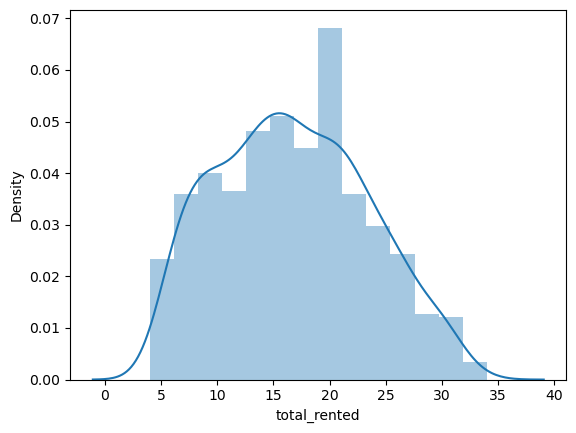

In [19]:
sns.distplot(data['total_rented'])
plt.show()

In [20]:
#I am creating clasffication for the number of total_rents. I prefer to use another table
df = data.copy()
df['renting_classified'] = data['total_rented'].apply(lambda x: 'low_renting' if x >= 0 and x <= 10 else ('medium_renting' if x >= 11 and x <= 20 else ('high_renting' if x >= 21 and x <= 30 else ('super_high_renting' if x >= 31 and x <= 40 else 'other'))))
df.head()


,film_id,title,rating,rental_rate,total_rented,rental_rate_classified,renting_classified
0,1,ACADEMY DINOSAUR,PG,0.99,24,low_rate,high_renting
1,2,ACE GOLDFINGER,G,4.99,7,high_rate,low_renting
2,3,ADAPTATION HOLES,NC-17,2.99,12,medium_rate,medium_renting
3,4,AFFAIR PREJUDICE,G,2.99,23,medium_rate,high_renting
4,5,AFRICAN EGG,G,2.99,12,medium_rate,medium_renting


In [21]:
df.renting_classified.value_counts()

medium_renting        459
high_renting          279
low_renting           204
super_high_renting     16
Name: renting_classified, dtype: int64

<span style="color:#FF1490">**2.** Now that we have created the renting_classified, lets encode this column and the rating column</span>

In [22]:
rating_enc = df['rating']
rating_enc_dumm = pd.get_dummies(rating_enc, drop_first=False)
rating_enc_dumm

,G,NC-17,PG,PG-13,R
0,0,0,1,0,0
1,1,0,0,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
953,1,0,0,0,0
954,0,1,0,0,0
955,0,1,0,0,0
956,0,0,0,0,1


In [23]:
rental_rate_classified_enc = df['rental_rate_classified']
rental_rate_classified_enc_dumm = pd.get_dummies(rental_rate_classified_enc, drop_first=False)
rental_rate_classified_enc_dumm

,high_rate,low_rate,medium_rate
0,0,1,0
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
953,0,1,0
954,0,1,0
955,0,1,0
956,0,0,1


In [24]:
df_cat = df.select_dtypes(include = np.object)
df_num = df.select_dtypes(include = np.number)

In [25]:
df_num = pd.concat([df_num, rental_rate_classified_enc_dumm, rating_enc_dumm], axis=1)
df_num

,film_id,rental_rate,total_rented,high_rate,low_rate,medium_rate,G,NC-17,PG,PG-13,R
0,1,0.99,24,0,1,0,0,0,1,0,0
1,2,4.99,7,1,0,0,1,0,0,0,0
2,3,2.99,12,0,0,1,0,1,0,0,0
3,4,2.99,23,0,0,1,1,0,0,0,0
4,5,2.99,12,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
953,996,0.99,7,0,1,0,1,0,0,0,0
954,997,0.99,6,0,1,0,0,1,0,0,0
955,998,0.99,9,0,1,0,0,1,0,0,0
956,999,2.99,17,0,0,1,0,0,0,0,1


### <span style="color:#FF1493">EDA</span>

<span style="color:#FF1490">The EDA will be focused on our **target: total_rented**</span>

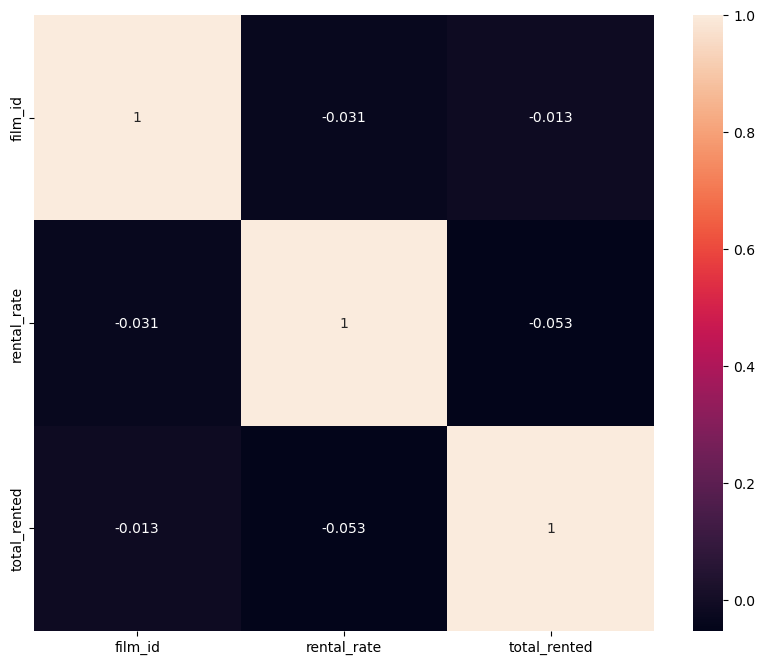

In [29]:
corr_matrix=df.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [109]:
import plotly.express as px
fig = px.bar(df, x='renting_classified')
fig.show()


In [27]:
fig = px.bar(df, x='renting_classified', y='rental_rate_classified', color='rental_rate_classified')
fig.show()



In [28]:
df.rental_rate_classified.value_counts()

low_rate       326
high_rate      320
medium_rate    312
Name: rental_rate_classified, dtype: int64

### <span style="color:#FF1493">Train-Test Split and Training Model</span>

In [29]:
df_num

,film_id,rental_rate,total_rented,high_rate,low_rate,medium_rate,G,NC-17,PG,PG-13,R
0,1,0.99,24,0,1,0,0,0,1,0,0
1,2,4.99,7,1,0,0,1,0,0,0,0
2,3,2.99,12,0,0,1,0,1,0,0,0
3,4,2.99,23,0,0,1,1,0,0,0,0
4,5,2.99,12,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
953,996,0.99,7,0,1,0,1,0,0,0,0
954,997,0.99,6,0,1,0,0,1,0,0,0
955,998,0.99,9,0,1,0,0,1,0,0,0
956,999,2.99,17,0,0,1,0,0,0,0,1


In [40]:
y = df['renting_classified'] # Target appart
X = df_num
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
len(X_train)

766

In [42]:
y_train

302          high_renting
467          high_renting
294        medium_renting
548        medium_renting
465    super_high_renting
              ...        
106          high_renting
270        medium_renting
860          high_renting
435           low_renting
102        medium_renting
Name: renting_classified, Length: 766, dtype: object

In [43]:
classification = LogisticRegression(random_state=0, multi_class='multinomial').fit(X_train, y_train)

In [44]:
predictions = classification.predict(X_test)

### <span style="color:#FF1493">Check how the model performs</span>

In [45]:
pd.Series(predictions).value_counts()

medium_renting    96
high_renting      59
low_renting       37
dtype: int64

In [46]:
y_test.value_counts()

medium_renting        92
high_renting          54
low_renting           41
super_high_renting     5
Name: renting_classified, dtype: int64

In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[39,  0, 15,  0],
       [ 0, 28, 13,  0],
       [15,  9, 68,  0],
       [ 5,  0,  0,  0]], dtype=int64)

In [48]:
cm1 = confusion_matrix(predictions,y_test)

In [49]:
classification.score(X_test, y_test)

0.703125

In [50]:
from sklearn.metrics import accuracy_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, predictions)))


Accuracy: 0.70



# <span style="color:purple">Option 2</span>

### <span style="color:purple">How am going to tackle this problem?</span>

<span style="color:purple">I am going to make a boolean if it was rented or not in february 2006 (the "last month") and I am going to target that column in the logistic regression.</span>

### <span style="color:purple">Get the data</span>

In [62]:

query2 = '''SELECT r.rental_id, f.film_id, f.title, f.rating, f.rental_rate, r.rental_date, i.inventory_id, i.store_id, r.staff_id
         FROM rental r 
         LEFT JOIN inventory i 
         USING (inventory_id) 
         JOIN film f 
         USING (film_id) 
         ORDER BY rental_date DESC'''

data2 = pd.read_sql_query(query2, engine)



### <span style="color:purple"> Pre-processing data</span>

In [63]:
# Create a new column indicating whether the rental date is in February 2006
data2['rented_in_feb_2006'] = data2['rental_date'].apply(lambda x: 1 if x.year == 2006 and x.month == 2 else 0)

data2.head()


,rental_id,film_id,title,rating,rental_rate,rental_date,inventory_id,store_id,staff_id,rented_in_feb_2006
0,16050,1,ACADEMY DINOSAUR,PG,0.99,2023-02-25 12:41:34,1,1,1,0
1,12988,17,ALONE TRIP,R,0.99,2006-02-14 15:16:03,81,1,2,1
2,13952,50,BAKED CLEOPATRA,G,2.99,2006-02-14 15:16:03,224,1,2,1
3,14374,53,BANG KWAI,NC-17,2.99,2006-02-14 15:16:03,236,1,2,1
4,13182,80,BLANKET BEVERLY,G,2.99,2006-02-14 15:16:03,364,1,2,1


In [60]:
data2['rented_in_feb_2006'].value_counts()
# Only 182 films in the inventory where rented in february 2006

0    15863
1      182
Name: rented_in_feb_2006, dtype: int64

 <span style="color:purple"> **Encoding**</span>

In [66]:
classify_rental_rate = lambda rate: 'low_rate' if rate == 0.99 else 'medium_rate' if rate == 2.99 else 'high_rate'

data2['rental_rate_classified'] = data2['rental_rate'].apply(classify_rental_rate)

In [67]:
rental_rate_classified_enc2 = data2['rental_rate_classified']
rental_rate_classified_enc_dumm2 = pd.get_dummies(rental_rate_classified_enc2, drop_first=False)
rental_rate_classified_enc_dumm2

,high_rate,low_rate,medium_rate
0,0,1,0
1,0,1,0
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
16040,0,0,1
16041,0,1,0
16042,0,0,1
16043,0,0,1


In [64]:
rating_enc2 = data2['rating']
rating_enc_dumm2 = pd.get_dummies(rating_enc2, drop_first=False)
rating_enc_dumm2

,G,NC-17,PG,PG-13,R
0,0,0,1,0,0
1,0,0,0,0,1
2,1,0,0,0,0
3,0,1,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
16040,0,1,0,0,0
16041,0,0,0,0,1
16042,1,0,0,0,0
16043,0,0,0,0,1


In [69]:
store_enc = data2['store_id']
store_enc_dumm = pd.get_dummies(store_enc, drop_first=False)
store_enc_dumm

,1,2
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
16040,0,1
16041,1,0
16042,0,1
16043,0,1


In [70]:
staff_enc = data2['staff_id']
staff_enc_dumm = pd.get_dummies(staff_enc, drop_first=False)
staff_enc_dumm

,1,2
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
16040,1,0
16041,0,1
16042,1,0
16043,1,0


In [71]:
df_cat2 = data2.select_dtypes(include = np.object)
df_num2 = data2.select_dtypes(include = np.number)

In [72]:
df_num2 = pd.concat([df_num2, rental_rate_classified_enc_dumm2, rating_enc_dumm2, store_enc_dumm, staff_enc_dumm], axis=1)
df_num2

,rental_id,film_id,rental_rate,inventory_id,store_id,staff_id,rented_in_feb_2006,high_rate,low_rate,medium_rate,G,NC-17,PG,PG-13,R,1,2,1,2
0,16050,1,0.99,1,1,1,0,0,1,0,0,0,1,0,0,1,0,1,0
1,12988,17,0.99,81,1,2,1,0,1,0,0,0,0,0,1,1,0,0,1
2,13952,50,2.99,224,1,2,1,0,0,1,1,0,0,0,0,1,0,0,1
3,14374,53,2.99,236,1,2,1,0,0,1,0,1,0,0,0,1,0,0,1
4,13182,80,2.99,364,1,2,1,0,0,1,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16040,5,450,2.99,2079,2,1,0,0,0,1,0,1,0,0,0,0,1,1,0
16041,4,535,0.99,2452,1,2,0,0,1,0,0,0,0,0,1,1,0,0,1
16042,3,373,2.99,1711,2,1,0,0,0,1,1,0,0,0,0,0,1,1,0
16043,2,333,2.99,1525,2,1,0,0,0,1,0,0,0,0,1,0,1,1,0


In [75]:
df_num2 = df_num2.drop(['store_id', 'staff_id', 'rental_rate'], axis=1)
df_num2

,rental_id,film_id,inventory_id,rented_in_feb_2006,high_rate,low_rate,medium_rate,G,NC-17,PG,PG-13,R,1,2,1,2
0,16050,1,1,0,0,1,0,0,0,1,0,0,1,0,1,0
1,12988,17,81,1,0,1,0,0,0,0,0,1,1,0,0,1
2,13952,50,224,1,0,0,1,1,0,0,0,0,1,0,0,1
3,14374,53,236,1,0,0,1,0,1,0,0,0,1,0,0,1
4,13182,80,364,1,0,0,1,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16040,5,450,2079,0,0,0,1,0,1,0,0,0,0,1,1,0
16041,4,535,2452,0,0,1,0,0,0,0,0,1,1,0,0,1
16042,3,373,1711,0,0,0,1,1,0,0,0,0,0,1,1,0
16043,2,333,1525,0,0,0,1,0,0,0,0,1,0,1,1,0


### <span style="color:purple">EDA</span>

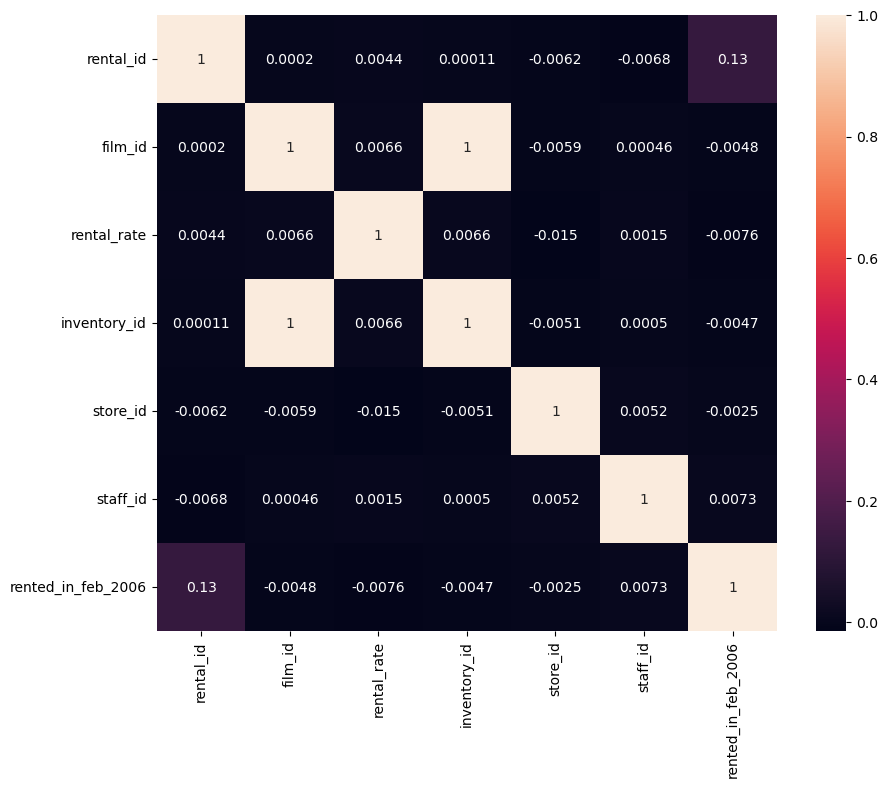

In [103]:
corr_matrix=data2.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [106]:
import plotly.express as px
fig = px.bar(data2, x='rental_rate_classified', color='rental_rate_classified',
             color_discrete_sequence=['#1f77b4', '#ff7f0e', '#2ca02c'])
fig.show()

### <span style="color:purple">Train-Test Split and Training Model</span>

In [89]:
y2 = df_num2['rented_in_feb_2006'] # Target appart
X2 = df_num2.drop(['rented_in_feb_2006'], axis=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [90]:
len(X_train2)

12836

In [91]:
y_train2

5576     0
15214    0
11385    0
9022     0
14708    0
        ..
13418    0
5390     0
860      0
15795    0
7270     0
Name: rented_in_feb_2006, Length: 12836, dtype: int64

In [96]:
classification2 = LogisticRegression(random_state=0, multi_class='multinomial').fit(X_train2, y_train2)

In [97]:
predictions2 = classification2.predict(X_test2)

### <span style="color:purple">Check how the model performs</span>

In [98]:
pd.Series(predictions2).value_counts()

0    3209
dtype: int64

In [95]:
y_test2.value_counts()

0    3167
1      42
Name: rented_in_feb_2006, dtype: int64

In [99]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test2, predictions2)

array([[3167,    0],
       [  42,    0]], dtype=int64)

In [100]:
cm2 = confusion_matrix(predictions2,y_test2)

In [101]:
classification2.score(X_test2, y_test)

0.9869118105328762

In [102]:
from sklearn.metrics import accuracy_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test2, predictions2)))


Accuracy: 0.99



<span style="color:#FF1490">The second model performs much better than the first one. </span>

### <span style="color:rgb(255, 0, 255)">Conclusion:The second model performs much better than the first one. This might be because I added more data related with each rental_id. Nevertheless, with this model with predict only in the inventory that was rented in last month, not in the film. I mean, in February a film might be rented a lot of times but they were different copies with different inventory_ids. We are predicting in the inventory_id, not in the film</span> 